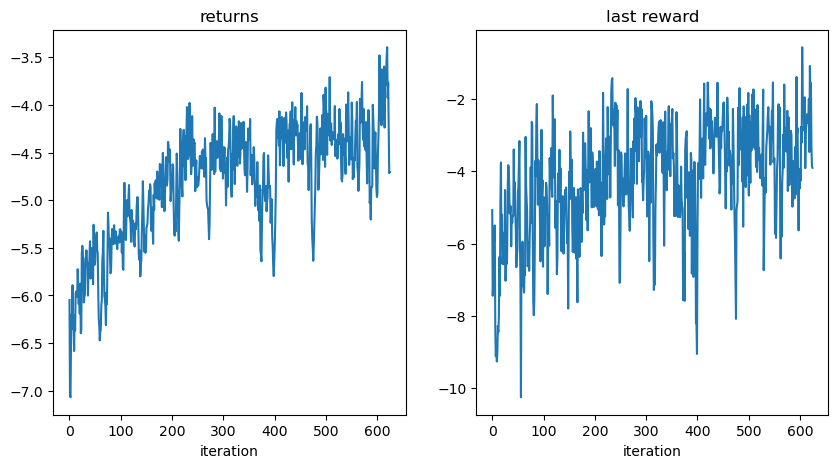

In [3]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

DEFAULT_X = np.pi
DEFAULT_Y = 1.0

def _step(tensordict):
    th, thdot = tensordict["th"], tensordict["thdot"]  # th := theta

    g_force = tensordict["params", "g"]
    mass = tensordict["params", "m"]
    length = tensordict["params", "l"]
    dt = tensordict["params", "dt"]
    u = tensordict["action"].squeeze(-1)
    u = u.clamp(-tensordict["params", "max_torque"], tensordict["params", "max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)

    new_thdot = (
        thdot
        + (3 * g_force / (2 * length) * th.sin() + 3.0 / (mass * length**2) * u) * dt
    )
    new_thdot = new_thdot.clamp(
        -tensordict["params", "max_speed"], tensordict["params", "max_speed"]
    )
    new_th = th + new_thdot * dt
    reward = -costs.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "th": new_th,
            "thdot": new_thdot,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )
    return out


def angle_normalize(x):
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)

    high_th = torch.tensor(DEFAULT_X, device=self.device)
    high_thdot = torch.tensor(DEFAULT_Y, device=self.device)
    low_th = -high_th
    low_thdot = -high_thdot

    # for non batch-locked environments, the input ``tensordict`` shape dictates the number
    # of simulators run simultaneously. In other contexts, the initial
    # random state's shape will depend upon the environment batch-size instead.
    th = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_th - low_th)
        + low_th
    )
    thdot = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_thdot - low_thdot)
        + low_thdot
    )
    out = TensorDict(
        {
            "th": th,
            "thdot": thdot,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        th=BoundedTensorSpec(
            low=-torch.pi,
            high=torch.pi,
            shape=(),
            dtype=torch.float32,
        ),
        thdot=BoundedTensorSpec(
            low=-td_params["params", "max_speed"],
            high=td_params["params", "max_speed"],
            shape=(),
            dtype=torch.float32,
        ),
        # we need to add the ``params`` to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, ``EnvBase`` expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    self.action_spec = BoundedTensorSpec(
        low=-td_params["params", "max_torque"],
        high=td_params["params", "max_torque"],
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

def gen_params(g=10.0, batch_size=None) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_speed": 8,
                    "max_torque": 1.0,
                    "dt": 0.05,
                    "g": g,
                    "m": 1.0,
                    "l": 1.0,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

class PendulumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

env = PendulumEnv()
check_env_specs(env)

print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

#td = env.reset()
#print("reset tensordict", td)

#td = env.rand_step(td)
#print("random step tensordict", td)

env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

class SinTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.sin()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


class CosTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.cos()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)

cat_transform = CatTensors(
    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)

check_env_specs(env)

def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

batch_size = 32
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()